In [ ]:
# PREAMBLE
# Packets

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, root_scalar

# Model params
w = 1.0
L = 16.0
nu = 0.015
eps = 1.0

# Tax params (Use tau* og zeta* from part 2)
tau_star = 0.5      # <- sæt til dit tau*
zeta_star = -0.1    # <- sæt til dit zeta* (skal være <= 0 i opg. 3)

# Top tax params
kappa = 9.0
omega = 0.2

# Productivity values
p_list = [1.0, 1.175, 1.5]


In [ ]:
# Model Setup: Income and Utility

def income_top_tax(l, p):
    """
    Efter-skat indkomst y(l) for en given produktivitet p under topskatssystemet.
    """
    gross = w * p * l                    # bruttoindkomst
    top_part = np.maximum(gross - kappa, 0.0)  # indkomst over topskattegrænsen
    return (1 - tau_star) * gross - omega * top_part - zeta_star


def utility(l, p):
    """
    Nytte: log(c) - nu * l^(1+eps)/(1+eps).
    Hvis c <= 0, gives meget lav nytte så løsningen fravælges.
    """
    c = income_top_tax(l, p)
    if c <= 0:
        return -1e10
    return np.log(c) - nu * l**(1 + eps) / (1 + eps)


In [ ]:
# Model Setup: FOCS (before and after kink)

def phi_before(l, p):
    """
    FOC før kink: marginal skat = tau_star.
    """
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star) * w * p / c - nu * l**eps


def phi_after(l, p):
    """
    FOC efter kink: marginal skat = tau_star + omega.
    """
    c = income_top_tax(l, p)
    if c <= 0:
        return 1e10
    return (1 - tau_star - omega) * w * p / c - nu * l**eps



In [11]:
# === SNIPPET 3: Løsningsfunktioner for en given p ===

def solve_by_optimizer(p):
    """
    Finder optimal l* ved at maksimere U(l, p) numerisk.
    """
    def obj(l):
        return -utility(l, p)   # vi minimerer -U(l)
    
    res = minimize_scalar(obj, bounds=(0.0, L), method="bounded")
    l_star = res.x
    return l_star, utility(l_star, p)


def solve_by_FOC(p):
    """
    Fire-trins FOC-metode for en given p:
      1) løsning før kink (b)
      2) kink-punktet (k)
      3) løsning efter kink (a)
      4) vælg den med højest nytte
    """
    l_k = kappa / (w * p)
    candidates = []

    # 1) Før kink
    if l_k > 1e-3:
        try:
            sol_b = root_scalar(phi_before, args=(p,),
                                bracket=(1e-3, min(l_k, L) - 1e-3),
                                method="bisect")
            if sol_b.converged:
                l_b = sol_b.root
                candidates.append(("b", l_b, utility(l_b, p)))
        except ValueError:
            pass

    # 2) Kink-punktet
    if 0 < l_k < L:
        candidates.append(("k", l_k, utility(l_k, p)))

    # 3) Efter kink
    if l_k < L - 1e-3:
        try:
            sol_a = root_scalar(phi_after, args=(p,),
                                bracket=(max(l_k + 1e-3, 1e-3), L),
                                method="bisect")
            if sol_a.converged:
                l_a = sol_a.root
                candidates.append(("a", l_a, utility(l_a, p)))
        except ValueError:
            pass

    # Hvis ingen løsning
    if len(candidates) == 0:
        return 0.0, utility(0.0, p), "none"

    # 4) Vælg den med højest nytte
    best_type, best_l, best_U = max(candidates, key=lambda x: x[2])
    return best_l, best_U, best_type


p = 1.0
  Optimizer:  l* = 8.0656, U = 0.9311
  FOC 4-trin: l* = 8.0656, U = 0.9311, type = b
p = 1.175
  Optimizer:  l* = 7.6596, U = 1.0860
  FOC 4-trin: l* = 7.6596, U = 1.0860, type = k
p = 1.5
  Optimizer:  l* = 6.3224, U = 1.2573
  FOC 4-trin: l* = 6.3224, U = 1.2573, type = a


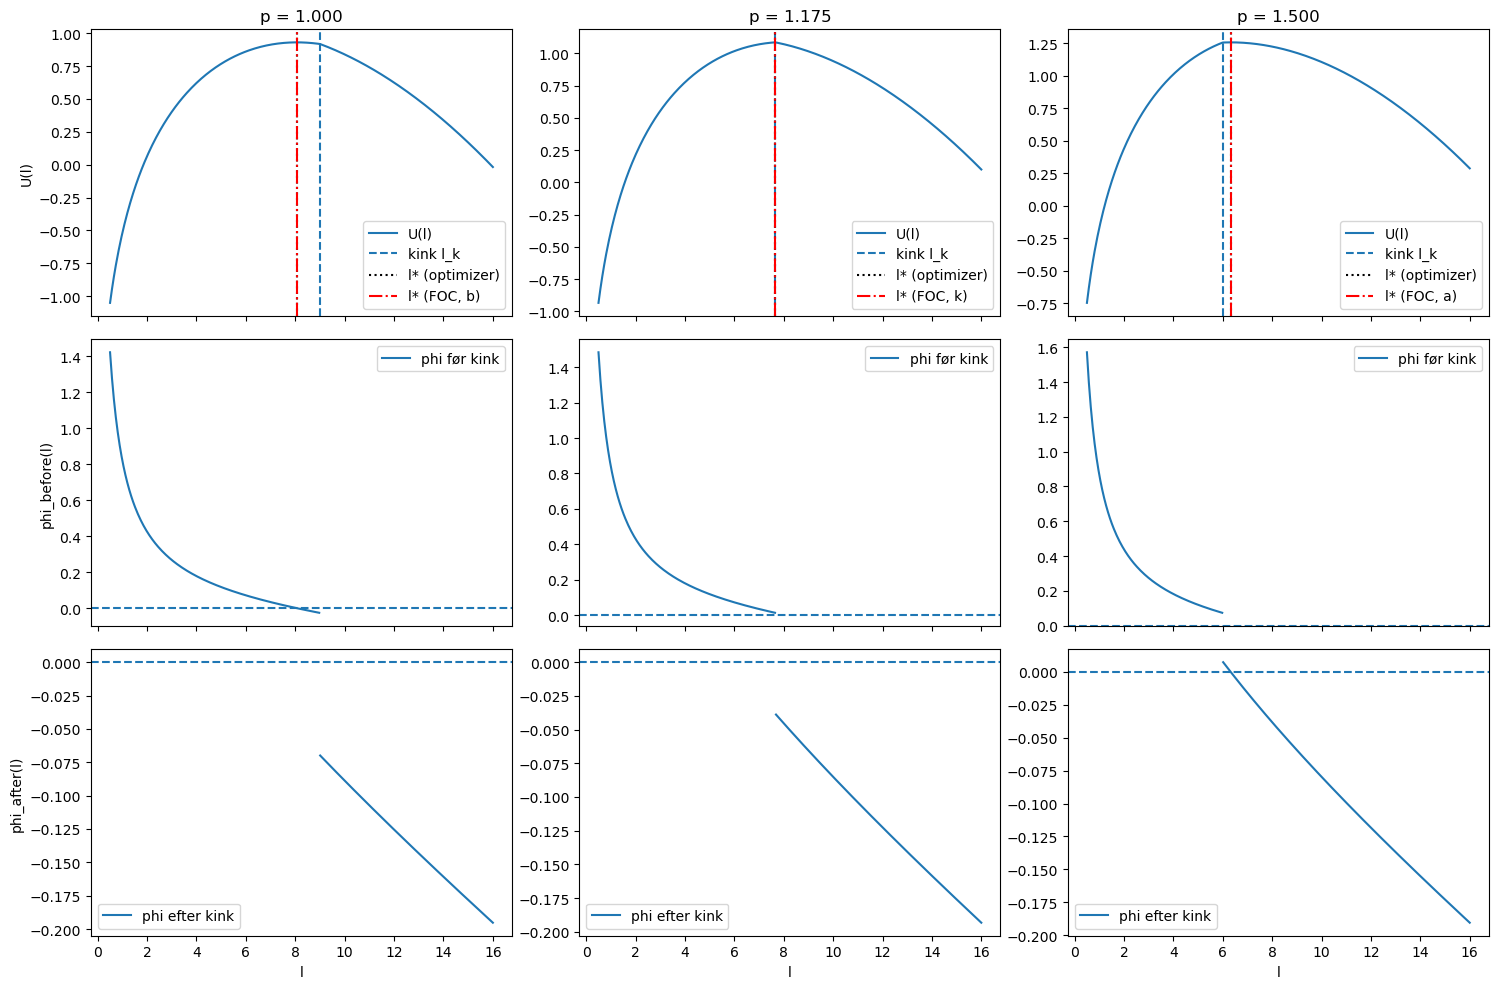

In [12]:
# === SNIPPET 4: Loop over p og lav samlet figur ===

# Laver en figur med 3 rækker (U, phi_before, phi_after) og 3 kolonner (en for hver p)
fig, axes = plt.subplots(3, len(p_list), figsize=(5 * len(p_list), 10), sharex=True)

# Hvis der kun var én p, ville axes være 1D, men her er der 3, så axes er 2D: [row, col]

for j, p in enumerate(p_list):
    # grid for l
    l_grid = np.linspace(0.5, L, 400)
    U_vals = np.array([utility(l, p) for l in l_grid])

    # kink-punkt
    l_k = kappa / (w * p)

    # phi før kink
    phi_before_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_before = l_grid < l_k
    phi_before_vals[mask_before] = [phi_before(l, p) for l in l_grid[mask_before]]

    # phi efter kink
    phi_after_vals = np.full_like(l_grid, np.nan, dtype=float)
    mask_after = l_grid > l_k
    phi_after_vals[mask_after] = [phi_after(l, p) for l in l_grid[mask_after]]

    # løsninger
    l_opt_num, U_opt_num = solve_by_optimizer(p)
    l_opt_foc, U_opt_foc, kind_foc = solve_by_FOC(p)

    print(f"p = {p}")
    print(f"  Optimizer:  l* = {l_opt_num:.4f}, U = {U_opt_num:.4f}")
    print(f"  FOC 4-trin: l* = {l_opt_foc:.4f}, U = {U_opt_foc:.4f}, type = {kind_foc}")

    # vælg de rette akser for denne kolonne
    ax_U   = axes[0, j]
    ax_phi_b = axes[1, j]
    ax_phi_a = axes[2, j]

    # (1) U(l)
    ax_U.plot(l_grid, U_vals, label="U(l)")
    ax_U.axvline(l_k, linestyle="--", label="kink l_k")
    ax_U.axvline(l_opt_num, color="black", linestyle=":", label="l* (optimizer)")
    ax_U.axvline(l_opt_foc, color="red", linestyle="-.", label=f"l* (FOC, {kind_foc})")
    ax_U.set_title(f"p = {p:.3f}")
    if j == 0:
        ax_U.set_ylabel("U(l)")
    ax_U.legend()

    # (2) phi før kink
    ax_phi_b.plot(l_grid, phi_before_vals, label="phi før kink")
    ax_phi_b.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_b.set_ylabel("phi_before(l)")
    ax_phi_b.legend()

    # (3) phi efter kink
    ax_phi_a.plot(l_grid, phi_after_vals, label="phi efter kink")
    ax_phi_a.axhline(0, linestyle="--")
    if j == 0:
        ax_phi_a.set_ylabel("phi_after(l)")
    ax_phi_a.set_xlabel("l")
    ax_phi_a.legend()

plt.tight_layout()
plt.show()



In [13]:
# === 3.2: Beregn l*(p) og c(p) for mange p-værdier ===

# grid af p-værdier (arbejdernes produktivitet)
p_grid = np.linspace(0.5, 3.0, 200)   # fx 200 punkter mellem 0.5 og 3.0

l_star_list = []
c_star_list = []
type_list   = []   # 'b', 'k', 'a' osv.

for p in p_grid:
    # brug din 4-trins FOC-løsning
    l_star, U_star, kind = solve_by_FOC(p)
    
    # gem resultater
    l_star_list.append(l_star)
    c_star_list.append(income_top_tax(l_star, p))  # c = y(p, l*)
    type_list.append(kind)

# konverter til numpy-arrays (nemmere at bruge i plots)
l_star_arr = np.array(l_star_list)
c_star_arr = np.array(c_star_list)
type_arr   = np.array(type_list)


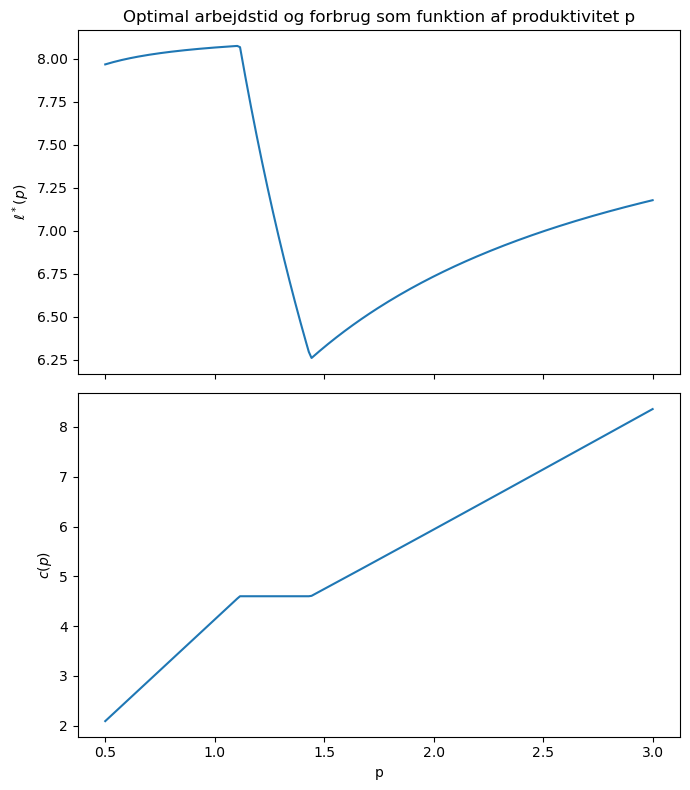

In [14]:
# === 3.2: Plot l*(p) og c(p) ===

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Øverste: arbejdsudbud som funktion af p
axes[0].plot(p_grid, l_star_arr)
axes[0].set_ylabel(r"$\ell^*(p)$")
axes[0].set_title("Optimal arbejdstid og forbrug som funktion af produktivitet p")

# Nederste: forbrug som funktion af p
axes[1].plot(p_grid, c_star_arr)
axes[1].set_ylabel(r"$c(p)$")
axes[1].set_xlabel("p")

plt.tight_layout()
plt.show()


In [15]:
# === 3.2: Andele med l* = l_b, l_k, l_a ===

N = len(type_arr)

share_b = np.mean(type_arr == "b")
share_k = np.mean(type_arr == "k")
share_a = np.mean(type_arr == "a")
share_other = 1.0 - (share_b + share_k + share_a)   # hvis der skulle være 'none' eller andet

print("Andele af p-grid med forskellige typer løsninger:")
print(f"  l* = l_b (før kink):   {share_b*100:.1f} %")
print(f"  l* = l_k (kink):       {share_k*100:.1f} %")
print(f"  l* = l_a (efter kink): {share_a*100:.1f} %")
print(f"  øvrige (fx 'none'):    {share_other*100:.1f} %")


Andele af p-grid med forskellige typer løsninger:
  l* = l_b (før kink):   24.5 %
  l* = l_k (kink):       13.0 %
  l* = l_a (efter kink): 62.5 %
  øvrige (fx 'none'):    0.0 %


In [16]:
# === 3.2: Andele med l* = l_b, l_k, l_a ===

N = len(type_arr)

share_b = np.mean(type_arr == "b")
share_k = np.mean(type_arr == "k")
share_a = np.mean(type_arr == "a")
share_other = 1.0 - (share_b + share_k + share_a)   # hvis der skulle være 'none' eller andet

print("Andele af p-grid med forskellige typer løsninger:")
print(f"  l* = l_b (før kink):   {share_b*100:.1f} %")
print(f"  l* = l_k (kink):       {share_k*100:.1f} %")
print(f"  l* = l_a (efter kink): {share_a*100:.1f} %")
print(f"  øvrige (fx 'none'):    {share_other*100:.1f} %")


Andele af p-grid med forskellige typer løsninger:
  l* = l_b (før kink):   24.5 %
  l* = l_k (kink):       13.0 %
  l* = l_a (efter kink): 62.5 %
  øvrige (fx 'none'):    0.0 %


In [21]:
# === 3.3 SNIPPET 0: Regeringsparametre og population ===

# Antal arbejdere og produktivitetsfordeling (fra opgaveteksten)
N = 100
sigma_p = 0.3          # spredning i log-normal fordeling

# Parametre til Social Welfare Function (SWF)
chi = 1/(2*N)
eta = 0.1

# Træk produktiviteter til N arbejdere
# Vi bruger en fast seed, så resultaterne kan genskabes
rng = np.random.default_rng(seed=2025)
p_pop = rng.lognormal(mean=-0.5 * sigma_p**2, sigma=sigma_p, size=N)

# p_pop er nu et array med N produktiviteter, som vi genbruger i 3.3.1-3.3.3


In [22]:
# === 3.3 SNIPPET 1: SWF-funktion med topskatssystem ===

def compute_swf_top_tax(tau, zeta, kappa_val, omega_val):
    """
    Beregner SWF for et topskattesystem givet (tau, zeta, kappa, omega).
    
    Bruger:
      - p_pop: array af produktiviteter for N arbejdere
      - solve_by_FOC(p): finder (l*, U*, type) for en given p
      - income_top_tax(l, p): giver efter-skat indkomst for en given l, p
    
    Returnerer:
      SWF  : Social Welfare Function (scalartal)
      T    : samlet skatteprovenu
      U_arr: array af individuel nytte U_i
    """
    global tau_star, zeta_star, kappa, omega

    # Gem gamle værdier, så vi kan sætte dem tilbage bagefter
    old_tau   = tau_star
    old_zeta  = zeta_star
    old_kappa = kappa
    old_omega = omega

    # Sæt midlertidigt de nye skattesystemparametre
    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    U_list = []
    tax_list = []

    for p in p_pop:
        # Husholdningens optimale valg under det aktuelle system
        l_star, U_star, kind = solve_by_FOC(p)

        # Forbrug (efter-skat indkomst)
        c_star = income_top_tax(l_star, p)

        # Bruttoindkomst
        gross = w * p * l_star

        # Skat = brutto - efter-skat indkomst
        tax_i = gross - c_star

        U_list.append(U_star)
        tax_list.append(tax_i)

    # Konverter til arrays
    U_arr = np.array(U_list)
    tax_arr = np.array(tax_list)

    # Samlet provenu og SWF
    T = np.sum(tax_arr)
    G = T
    SWF = chi * (G**eta) + np.sum(U_arr)

    # Sæt de globale parametre tilbage til deres tidligere værdier
    tau_star  = old_tau
    zeta_star = old_zeta
    kappa     = old_kappa
    omega     = old_omega

    return SWF, T, U_arr


In [23]:
# === 3.3 SNIPPET 2: 3.3.1 – SWF uden og med topskat ===

# Brug de tau* og zeta* du har fundet tidligere
tau_opt = tau_star
zeta_opt = zeta_star

# 1) Baseline: ingen topskat (omega = 0, meget høj kappa)
swf_base, T_base, U_base = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,   # meget stor => næsten ingen rammes af topskatten
    omega_val=0.0
)

# 2) Med topskat: kappa = 9, omega = 0.2 (som i opgaven)
swf_top, T_top, U_top = compute_swf_top_tax(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

print("=== 3.3.1: SWF og provenu ===")
print(f"SWF uden topskat: {swf_base:.4f}")
print(f"SWF med topskat : {swf_top:.4f}")
print(f"Skatteprovenu uden topskat: {T_base:.4f}")
print(f"Skatteprovenu med topskat : {T_top:.4f}")


=== 3.3.1: SWF og provenu ===
SWF uden topskat: 87.8300
SWF med topskat : 86.4747
Skatteprovenu uden topskat: 393.7101
Skatteprovenu med topskat : 372.0206


In [24]:
# === 3.3 SNIPPET 3: Hjælpefunktioner til Lorenz-kurver ===

def compute_consumption_distribution(tau, zeta, kappa_val, omega_val):
    """
    Beregner forbrug c_i for alle arbejdere under et givet skattesystem.
    Returnerer et array c_arr med længde N.
    """
    global tau_star, zeta_star, kappa, omega
    old_tau, old_zeta, old_kappa, old_omega = tau_star, zeta_star, kappa, omega

    tau_star = tau
    zeta_star = zeta
    kappa = kappa_val
    omega = omega_val

    c_list = []
    for p in p_pop:
        l_star, U_star, kind = solve_by_FOC(p)
        c_star = income_top_tax(l_star, p)
        c_list.append(c_star)

    # reset parametre
    tau_star, zeta_star, kappa, omega = old_tau, old_zeta, old_kappa, old_omega

    return np.array(c_list)


def lorenz_curve(c_arr):
    """
    Beregner Lorenz-kurvens punkter for et array af konsumtion.
    Returnerer to arrays:
      cum_pop  : kumuleret andel af befolkningen (0 til 1)
      cum_cons : kumuleret andel af konsumtion (0 til 1)
    """
    c_sorted = np.sort(c_arr)
    cum_cons = np.cumsum(c_sorted)
    total_cons = cum_cons[-1]
    cum_cons_share = cum_cons / total_cons
    cum_pop_share = np.linspace(0, 1, len(c_arr), endpoint=True)
    return cum_pop_share, cum_cons_share


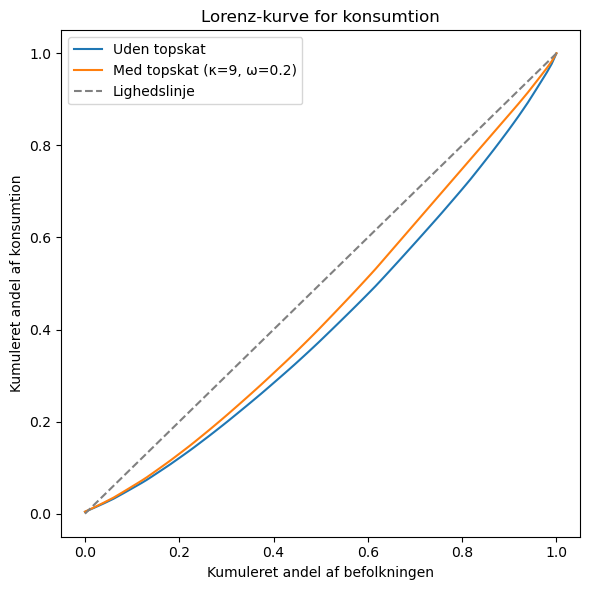

In [25]:
# === 3.3 SNIPPET 4: 3.3.2 – Plot Lorenz-kurver ===

# konsumtion uden topskat
c_base = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=1e6,
    omega_val=0.0
)

# konsumtion med topskat (kappa=9, omega=0.2)
c_top = compute_consumption_distribution(
    tau=tau_opt,
    zeta=zeta_opt,
    kappa_val=9.0,
    omega_val=0.2
)

# beregn Lorenz-kurver
pop_base, cons_base = lorenz_curve(c_base)
pop_top, cons_top   = lorenz_curve(c_top)

# plot
plt.figure(figsize=(6, 6))
plt.plot(pop_base, cons_base, label="Uden topskat")
plt.plot(pop_top, cons_top, label="Med topskat (κ=9, ω=0.2)")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Lighedslinje")
plt.xlabel("Kumuleret andel af befolkningen")
plt.ylabel("Kumuleret andel af konsumtion")
plt.title("Lorenz-kurve for konsumtion")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# === 3.3 SNIPPET 5: 3.3.3 – Grid search over (kappa, omega) ===

# definer grid af kappa og omega
omega_grid = np.linspace(0.0, 0.3, 7)     # fx 0.00, 0.05, ..., 0.30
kappa_grid = np.linspace(7.0, 11.0, 9)    # fx 7.0, 7.5, ..., 11.0

best_swf = -1e18
best_kappa = None
best_omega = None

for om in omega_grid:
    for kap in kappa_grid:
        swf_val, T_val, U_arr = compute_swf_top_tax(
            tau=tau_opt,
            zeta=zeta_opt,
            kappa_val=kap,
            omega_val=om
        )
        if swf_val > best_swf:
            best_swf = swf_val
            best_kappa = kap
            best_omega = om

print("=== 3.3.3: Bedste topskat i gridet ===")
print(f"Bedste SWF: {best_swf:.4f}")
print(f"kappa*     = {best_kappa:.3f}")
print(f"omega*     = {best_omega:.3f}")
print(f"SWF uden topskat (baseline): {swf_base:.4f}")


=== 3.3.3: Bedste topskat i gridet ===
Bedste SWF: 87.8300
kappa*     = 7.000
omega*     = 0.000
SWF uden topskat (baseline): 87.8300
